# Detection and Classification of Military Planes: A Comparative Study of CNN, YOLO, Faster R-CNN, RetinaNet, and EfficientDet


---

In the midst of the ongoing war in Ukraine, the ability to accurately detect and classify military aircraft is of critical importance for surveillance, defense, and strategic planning. This capability can significantly contribute to national security and defense efforts.

Traditionally, image recognition tasks have relied on simple Convolutional Neural Networks (CNNs) for their relatively straightforward architecture and ease of implementation. However, with the availability of more complex models such as YOLO (You Only Look Once), Faster R-CNN, RetinaNet, and EfficientDet, the potential for higher accuracy and faster detection speeds has increased.

This project seeks to explore and compare the performance of these advanced models against a simple CNN baseline for the task of military aircraft detection and classification. By conducting this comparative study, I aim to identify the most suitable model for practical applications in military contexts.

I have decided to use a Military Aircraft Recognition dataset from the kaggle.com. This dataset include 3842 images, 20 types, and 22341 instances annotated with horizontal bounding boxes and oriented bounding boxes.

In order to simplify work I have downloaded all the dataset into my git repository. Lets start by importing our project code and data from the git repository:


In [ ]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

fatal: destination path 'HawkEye' already exists and is not an empty directory.


Now lets do some import of the dependecies and look at our data:

Number of samples: 3842
Image shape:       (800, 800, 3)


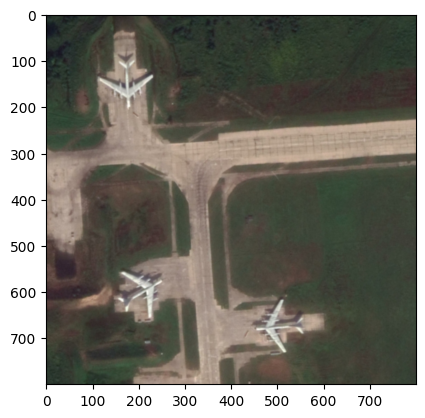

In [ ]:
import os
import itertools
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import random
from collections import defaultdict
from tqdm.notebook import tqdm
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

data_dir = 'HawkEye/Data'

imfiles = os.listdir(os.path.join(data_dir, 'Images'))
imfiles = [os.path.join(data_dir, 'Images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)
print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

In order to verify if our images have same size I will iterate all of them and clasify by shape:

In [ ]:
# Dictionary to store the count of images for each shape
image_shapes = defaultdict(int)

for imfile in tqdm(imfiles):
    image = cv2.imread(imfile)
    if image is not None:
        shape = image.shape
        image_shapes[shape] += 1

# Iterate over all images and collect information about their shapes
for shape, count in image_shapes.items():
    print(f'Shape: {shape}, Count: {count}')

  0%|          | 0/3842 [00:00<?, ?it/s]

Shape: (867, 854, 3), Count: 1
Shape: (800, 800, 3), Count: 3167
Shape: (833, 836, 3), Count: 1
Shape: (887, 842, 3), Count: 1
Shape: (635, 742, 3), Count: 1
Shape: (837, 802, 3), Count: 1
Shape: (847, 772, 3), Count: 1
Shape: (751, 751, 3), Count: 7
Shape: (844, 865, 3), Count: 1
Shape: (624, 821, 3), Count: 1
Shape: (737, 737, 3), Count: 3
Shape: (817, 837, 3), Count: 1
Shape: (738, 834, 3), Count: 1
Shape: (864, 826, 3), Count: 1
Shape: (638, 1055, 3), Count: 1
Shape: (757, 742, 3), Count: 1
Shape: (723, 877, 3), Count: 1
Shape: (747, 1035, 3), Count: 1
Shape: (784, 924, 3), Count: 1
Shape: (720, 938, 3), Count: 1
Shape: (747, 747, 3), Count: 7
Shape: (786, 773, 3), Count: 1
Shape: (661, 767, 3), Count: 1
Shape: (673, 816, 3), Count: 1
Shape: (735, 735, 3), Count: 6
Shape: (752, 752, 3), Count: 3
Shape: (628, 858, 3), Count: 1
Shape: (787, 817, 3), Count: 1
Shape: (822, 838, 3), Count: 1
Shape: (796, 796, 3), Count: 1
Shape: (750, 750, 3), Count: 11
Shape: (726, 817, 3), Count: 1
Sh

As we can see there is a big veriety of the image shapes yet the main claster is Shape: (800, 800, 3), Count: 3167. This will be the base of our dataset:

In [ ]:
# Define function to read annotations
def read_annotations(xml_path):
    # Parse the XML file
    tree = ET.parse(xml_path)

    # Get the root element of the XML tree
    root = tree.getroot()

    # Initialize an empty list to store the annotations
    annotations = []

    # Loop through <object> elements in the XML
    for obj in root.findall('object'):
        # Extract the label from the <name> element
        name = obj.find('name').text

        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))

    # Return the list of annotations
    return annotations

# Define function to read images and annotations
def read_data(file_names, data_dir):
    data = []
    dims = []
    labels = []

    # Loop over the file names extracted and read the images and annotations
    for file_name in file_names:
        # Get the paths to the files
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')

        # Read the image
        img = Image.open(img_path)

        # Filter out images that are not 800x800
        if img.size != (800, 800):
            continue

        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img_path, annotations))

    return data, labels, dims

# Get the list of filenames (without extension)
file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]

# Read the data
data, labels, dims = read_data(file_names, data_dir)

Lets display some more of the random samples from our dataset, already with proper annotations:

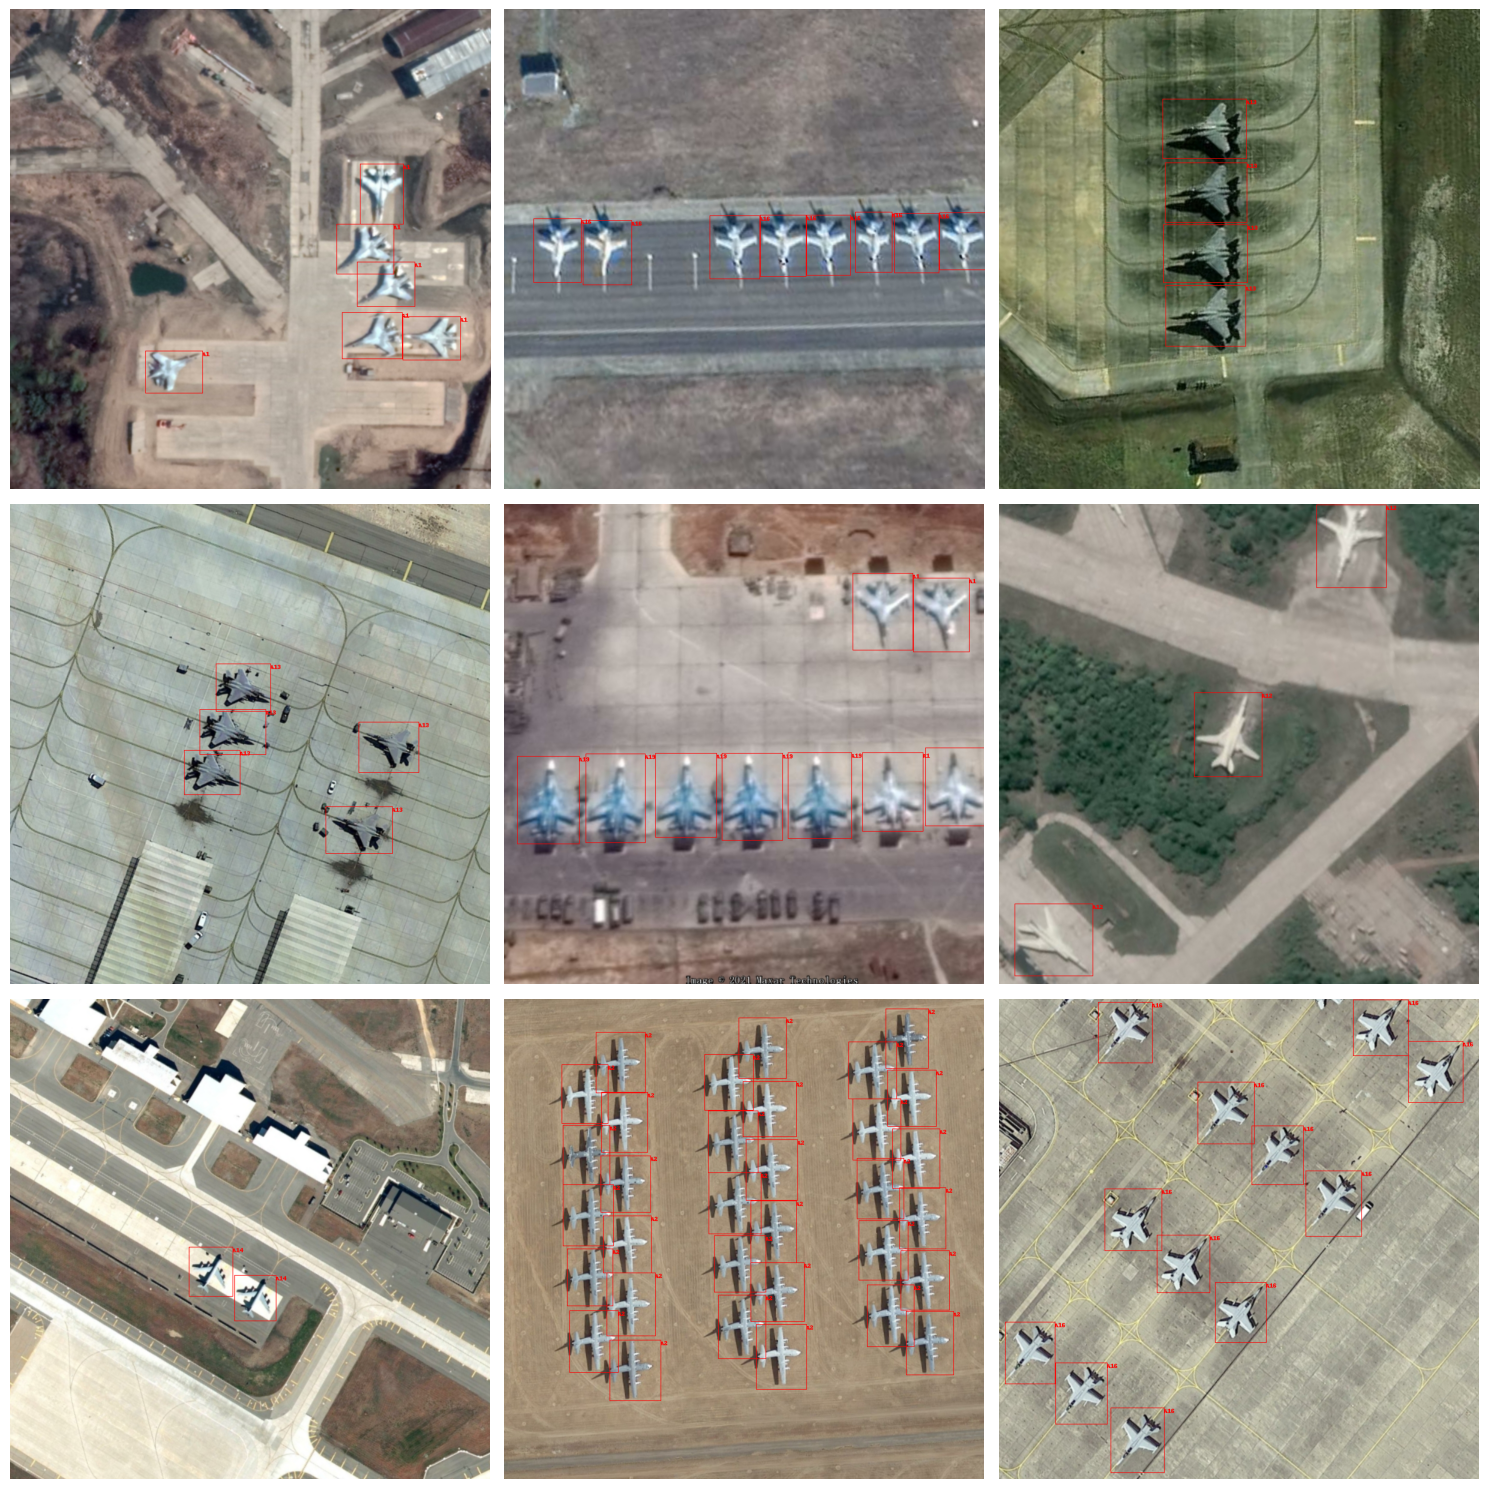

In [ ]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax in axes:
    idx = np.random.randint(0, len(data) - 1)
    img_path = data[idx][0]
    annotations = data[idx][1]
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)

    # Draw annotations on the image
    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        font_size = 100
        draw.text((xmax, ymin), label, fill='red')

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

I would like to visualise some additional properties of the dataset we will work with:

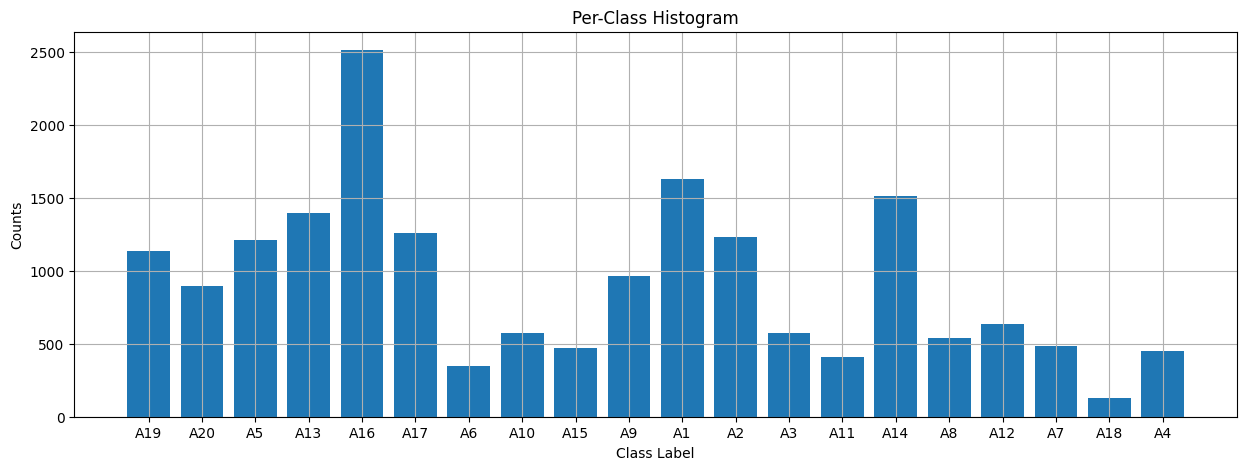

In [ ]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()


In [ ]:
# Print the per-class distribution
hist = Counter(labels)
sorted_hist = dict(sorted(hist.items()))

# Display the per-class distribution as text
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 1628 instances
Class A10: 572 instances
Class A11: 410 instances
Class A12: 633 instances
Class A13: 1397 instances
Class A14: 1514 instances
Class A15: 473 instances
Class A16: 2515 instances
Class A17: 1263 instances
Class A18: 125 instances
Class A19: 1138 instances
Class A2: 1235 instances
Class A20: 899 instances
Class A3: 575 instances
Class A4: 453 instances
Class A5: 1215 instances
Class A6: 346 instances
Class A7: 485 instances
Class A8: 539 instances
Class A9: 965 instances


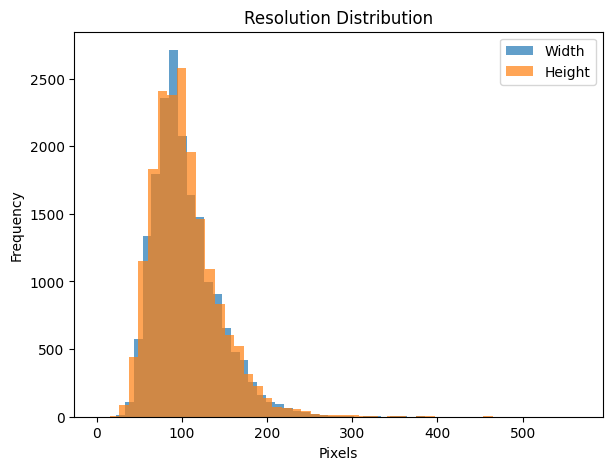

In [ ]:
# Analyze resolution distribution
resolutions = pd.DataFrame(dims, columns=['Width', 'Height'])

# Plot resolution distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(resolutions['Width'], bins=50, alpha=0.7, label='Width')
plt.hist(resolutions['Height'], bins=50, alpha=0.7, label='Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Resolution Distribution')
plt.legend()
plt.show()

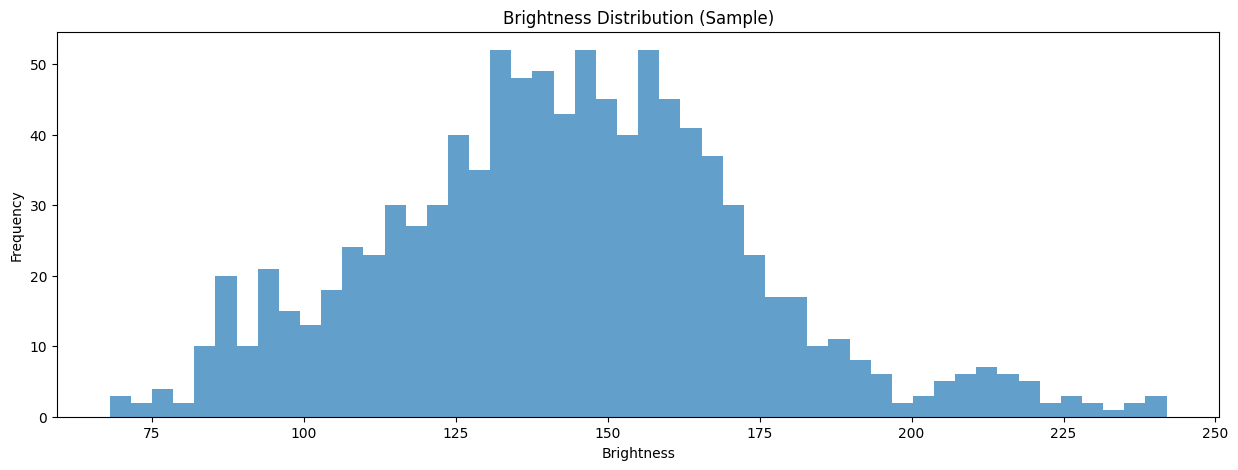

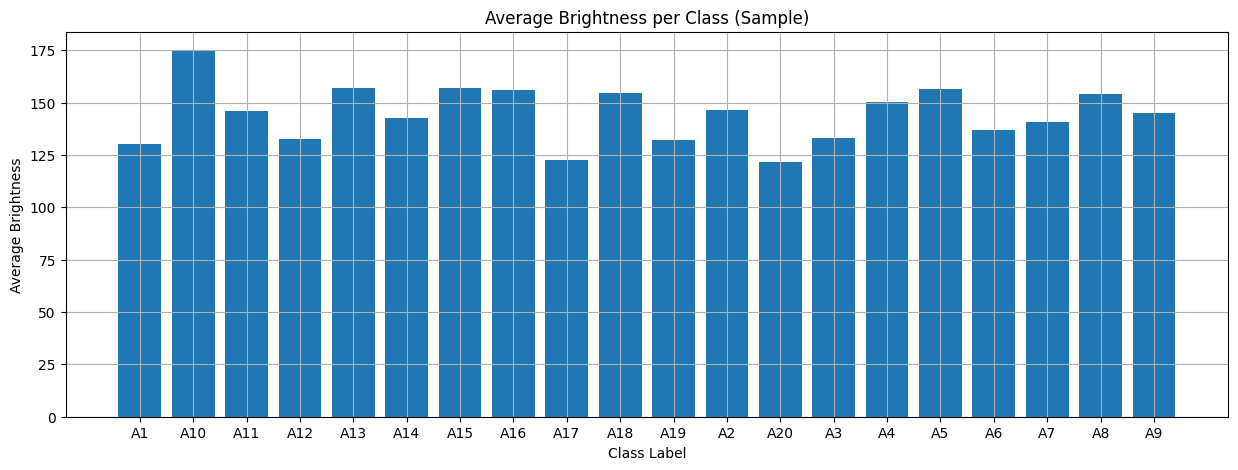

In [ ]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img_path = data[idx][0]
    img = Image.open(img_path).convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

# Brightness distribution per class for the sample
sample_labels = [data[idx][1][0][0] for idx in sample_data_indices]
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()



I am a bit worried by severely unequal per-class distribution and would like to mitigate the risks of some classes undertraining

In [ ]:
# Adjust the DataGenerator class to resize images
class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=32, dim=(256, 256), n_channels=3, n_classes=20, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.data[k] for k in indexes]
        X, y = self.__data_generation(batch_data)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_data):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, (img_path, annotations) in enumerate(batch_data):
            img = Image.open(img_path).resize(self.dim)
            img = np.array(img) / 255.0
            X[i,] = img
            labels = [self.labels.index(annot[0]) for annot in annotations]
            y[i,] = to_categorical(labels, num_classes=self.n_classes).sum(axis=0)
        return X, y

# Prepare data and labels
class_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20']
labels = [class_names.index(label) for label in class_names]

train_generator = DataGenerator(train_data, class_names, batch_size=16)  # Smaller batch size
validation_generator = DataGenerator(validation_data, class_names, batch_size=16, shuffle=False)

In [ ]:
# Define the simple CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(class_names), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

# Plot training history
import matplotlib.pyplot as plt

In [ ]:
# Show training history
h = history_cnn.history
epochs = range(len(h['loss']))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122)
plt.plot(epochs, h['accuracy'], '.-', epochs, h['val_accuracy'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])


YOLO

In [ ]:
!pip install -U ultralytics

import torch
from ultralytics import YOLO

# Load YOLO model
yolo_model = YOLO('yolov5s.pt')

# Define your custom dataset and train the model
# data.yaml should be created based on your dataset structure
yolo_model.train(data='data.yaml', epochs=30, imgsz=640)

# Validate the model
yolo_results = yolo_model.val()

# Show results
print(yolo_results)

In [ ]:
Faster R-CNN

In [ ]:
# Load Faster R-CNN model
fasterrcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = len(set(labels)) + 1  # +1 for background
in_features = fasterrcnn_model.roi_heads.box_predictor.cls_score.in_features
fasterrcnn_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Training and validation code for Faster R-CNN
# This code should include dataloader setup and training loop

RetinaNet

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn

# Load the pre-trained RetinaNet model
retinanet_model = retinanet_resnet50_fpn(pretrained=True)
num_classes = len(set(labels)) + 1  # +1 for background
in_features = retinanet_model.head.classification_head.conv[0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = torchvision.models.detection.retinanet.RetinaNetHead(in_features, num_anchors, num_classes)

# Training RetinaNet
# Similar training and validation code here

EfficientDet

In [ ]:
!pip install -U effdet

from effdet import create_model
from effdet.evaluator import evaluate

# Load EfficientDet model
effdet_model = create_model('tf_efficientdet_d0', num_classes=len(set(labels)) + 1)

# Training and validation code for EfficientDet
# Similar training and validation code here

Evaluation of the models

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

# Placeholder for storing evaluation results
evaluation_results = {}

# Function to evaluate a model
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    precision = precision_score(y_val, y_pred, average='macro')
    recall = recall_score(y_val, y_pred, average='macro')
    f1 = f1_score(y_val, y_pred, average='macro')
    mAP = average_precision_score(y_val, y_pred, average='macro')
    return precision, recall, f1, mAP

# Evaluate CNN model
precision, recall, f1, mAP = evaluate_model(cnn_model, X_val, y_val)
evaluation_results['CNN'] = (precision, recall, f1, mAP)

# Evaluate YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Inference Time

In [ ]:
import time

# Function to measure inference time
def measure_inference_time(model, X_val):
    start_time = time.time()
    model.predict(X_val)
    end_time = time.time()
    inference_time = end_time - start_time
    return inference_time

# Measure inference time for CNN model
inference_time_cnn = measure_inference_time(cnn_model, X_val)
evaluation_results['CNN'] += (inference_time_cnn,)

# Measure inference time for YOLO model
# Similar code for YOLO, Faster R-CNN, RetinaNet, and EfficientDet

Conclusion

In [ ]:
# Print evaluation results
for model_name, metrics in evaluation_results.items():
    precision, recall, f1, mAP, inference_time = metrics
    print(f"Model: {model_name}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"Mean Average Precision (mAP): {